In [1]:
import numpy as np
import glob
import datetime
from pmap import getmap
import pandas
import os
import lxml.etree as et
from netCDF4 import Dataset
import sys

In [2]:
%matplotlib notebook

## Read tide gauges data

In [3]:
OFILE='/mnt/pandora/Projects_Critech/EX_2015_CoastAlRisk/maps/data/s_b_data.txt'

In [4]:
obs=pandas.read_csv(OFILE,delimiter='\t')

In [5]:
obs

,ID,NAME,latobs,lonobs,latcalc,loncalc
0,1630,Almeira,36.8300,-2.4800,36.72506,-2.468386
1,1706,Valencia,39.4400,-0.3100,39.44040,-0.299000
2,819,Barcelona,41.3400,2.1600,41.27749,2.213909
3,1461,Palma de Mallorca,39.5600,2.6380,39.39457,2.614552
4,1741,Sete,43.3976,3.6991,43.31857,3.761195
5,1500,Corsica,42.9670,9.3500,43.09528,9.267036
6,1841,Carloforte,39.1480,8.3095,39.22599,8.231240
7,1848,Imperia,43.8783,8.0189,43.83057,8.149480
8,1846,Genova,44.4101,8.9255,44.32259,8.919400
9,1843,Civitavecchia,42.0940,11.7896,41.99920,11.677270


## Read HyFlux data

In [6]:
# define year
Y=2015

In [7]:
PATH='/mnt/ECMWF/processed/{}/FIX_MED_SEA/'.format(Y)  # ECMWF

### read bathymetry of first folder to define grid

In [8]:
folders=glob.glob(PATH+'calc_*')

In [9]:
filename=folders[0]+'/bathymetry.tif'
grid = getmap(filename)

gt=grid.GeoTr

width=grid.NCOLS
height=grid.NROWS

minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5]
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3]

lon=np.linspace(minx,maxx,width,endpoint=True)
lat=np.linspace(miny,maxy,height,endpoint=True)


### define start time of runs

In [10]:
odate=datetime.datetime.strptime(folders[0][-11:],'%Y%m%d.%H')
print odate

2015-01-01 00:00:00


We can check the restart date by parsing the locations.xml file ...

In [11]:
folders[0]+'/locations.xml'

'/mnt/ECMWF/processed/2015/FIX_MED_SEA/calc_20150101.00/locations.xml'

In [12]:
tree0=et.ElementTree(file=folders[0]+'/locations.xml')
for elem in list(tree0.getiterator()):
    if elem.tag == 'pubDate':
                 tinit=datetime.datetime.strptime(elem.text,'%d %b %Y %H:%M')
                 break
tinit

datetime.datetime(2015, 1, 1, 0, 0)

In [13]:
#SELECT POINT from database above
point=14

In [14]:
plat,plon=obs['latcalc'][point],obs['loncalc'][point]

In [15]:
i=np.abs(lat-plat).argmin()
j=np.abs(lon-plon).argmin()


In [16]:
print i,j

216 292


In [17]:
obs['ID'][point]

1866

### specify dates 

In [40]:
t0='20150421.12'

In [41]:
t1='20150423.00'

In [42]:
tstart=datetime.datetime.strptime(t0,'%Y%m%d.%H')
tend=datetime.datetime.strptime(t1,'%Y%m%d.%H')


In [43]:
dt=(tend-tstart).total_seconds()
ndt=dt/(3600*12)
ndt=np.int(ndt)+1


## read from netCDF files

In [44]:
combined=[] # store time and height
tw=[]
tstamp = [] # for use later

In [45]:
# define the 
dt0=0
dt1=72

In [46]:
for it in range(ndt):
    idate=tstart+datetime.timedelta(hours=12*it)
    dstamp=datetime.datetime.strftime(idate,'%Y%m%d.%H')
    
    # track completion
    sys.stdout.write('\r')
    sys.stdout.write(dstamp)
    sys.stdout.flush() 

    try:
        tree0=et.ElementTree(file=PATH+'calc_{}/locations.xml'.format(dstamp))
        for elem in list(tree0.getiterator()):
            if elem.tag == 'pubDate':
                tn=datetime.datetime.strptime(elem.text,'%d %b %Y %H:%M')
                break
        if tn != tinit :
            sys.stdout.write( '  > restart date : {}'.format(tn)) # new restart day
            tinit=tn
        
    except:
        sys.stdout.write('  > problem with locations.xml file')
        pass


    try:

        filename=PATH+'calc_{}/NETCDF_H.nc'.format(dstamp)
        d =  Dataset(filename)
        ha=d.variables['HA'][:,i,j] # all values
        t=d.variables['TIME'][:]
        
        tp=[]
        for ts in t:
            if t[0] == 0 :
                tp.append(idate+datetime.timedelta(seconds=ts))
                tinit=idate
            else:
                tp.append(tinit+datetime.timedelta(seconds=ts))
                       
        iw1=np.argwhere(np.array(tp)==idate+datetime.timedelta(hours=dt0)).flatten()[0]
        
        # check availability of values and take the minimum
        tmax=(t[-1]-t[iw1])/3600.
        tlimit=min(datetime.timedelta(hours=tmax),datetime.timedelta(hours=dt1))
        
        iw2=np.argwhere(np.array(tp)==idate+datetime.timedelta(seconds=tlimit.total_seconds())).flatten()[0]
                
        tw.append(tp[iw1:iw2+1])
        combined.append(ha[iw1:iw2+1])
        
        tstamp.append(dstamp)

    except Exception as e:
        sys.stdout.write('  > {}'.format(e))
        sys.stdout.write('  > problem with netcdf file, skiping'.format(dstamp))
        sys.stdout.write('\n')        




20150422.00  > problem with locations.xml file  > No such file or directory  > problem with netcdf file, skiping
20150422.12  > problem with locations.xml file  > No such file or directory  > problem with netcdf file, skiping
20150423.00

In [47]:
#Create the MultiIndex
rt=[]
k=0
for ida in tstamp:
    g=np.size(tw[k])*[ida]
    gr=[]
    for ti in g:
        gr.append(datetime.datetime.strptime(ti,'%Y%m%d.%H'))
    rt=np.append(rt,gr)
    k += 1

In [48]:
index=[np.array(rt).ravel(),[item for sublist in tw for item in sublist]]

In [49]:
pIndex=pandas.MultiIndex.from_arrays(index,names=['run date','time'])

In [50]:
data=[item for sublist in combined for item in sublist] # unravel list

In [51]:
res=pandas.DataFrame(data,index=pIndex,columns=['h - netCDF'])

<IPython.core.display.Javascript object>


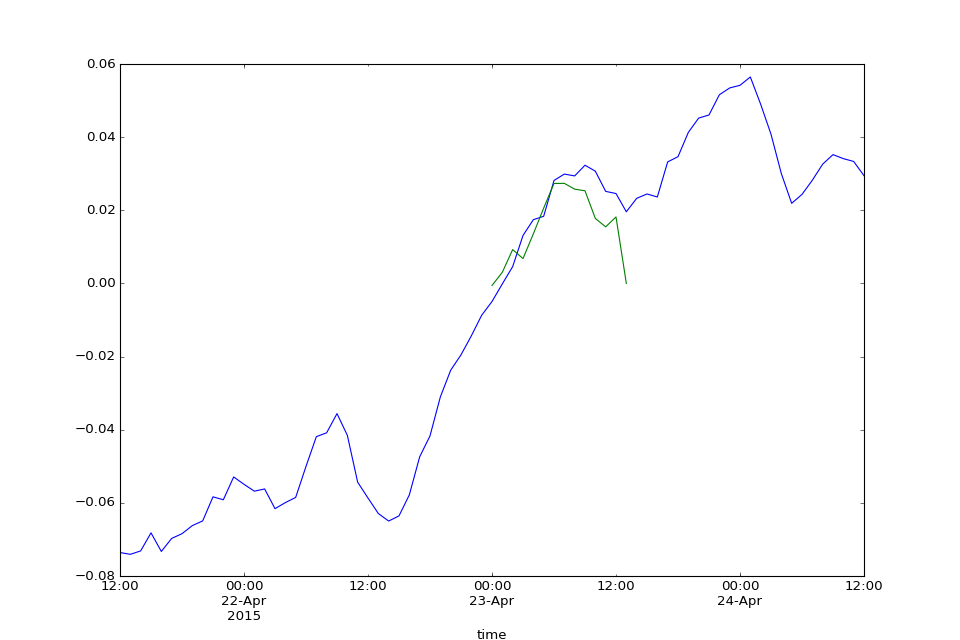

In [52]:
#plot
ax=res.unstack(level=0).plot(figsize=(12,8),legend=False)

### Reading from tif files

In [53]:
combined=[] # store time and height
tw=[]
tstamp = [] # for use later

In [54]:
for it in range(ndt):
    idate=tstart+datetime.timedelta(hours=12*it)
    dstamp=datetime.datetime.strftime(idate,'%Y%m%d.%H')
    
    # track completion
    sys.stdout.write('\r')
    sys.stdout.write(dstamp)
    sys.stdout.flush() 

    try:
        tree0=et.ElementTree(file=PATH+'calc_{}/locations.xml'.format(dstamp))
        for elem in list(tree0.getiterator()):
            if elem.tag == 'pubDate':
                tn=datetime.datetime.strptime(elem.text,'%d %b %Y %H:%M')
                break
        if tn != tinit :
            sys.stdout.write( '  > restart date : {}'.format(tn)) # new restart day
            tinit=tn
        
    except:
        sys.stdout.write('  > problem with locations.xml file')
        pass


    try:
        hfiles=glob.glob(PATH+'calc_{}/TIF_H*.tif'.format(dstamp))

        t=[np.int(l.split('_')[-1].split('.')[0]) for l in hfiles]
        
        
        # choose the files from the first 12 hours
        tp=[]
        for ts in t:
            if t[0] == 0 :
                tp.append(idate+datetime.timedelta(seconds=ts))
                tinit=idate
            else:
                tp.append(tinit+datetime.timedelta(seconds=ts))
                       
        iw1=np.argwhere(np.array(tp)==idate+datetime.timedelta(hours=dt0)).flatten()[0]
    
        # check availability of values and take the minimum

        tmax=(t[-1]-t[iw1])/3600.  # compute all values after the current run timestamp
        tlimit=min(datetime.timedelta(hours=tmax),datetime.timedelta(hours=dt1)) 

        iw2=np.argwhere(np.array(tp)==idate+datetime.timedelta(seconds=tlimit.total_seconds())).flatten()[0]
        tw.append(tp[iw1:iw2+1])
                
        
        for ifile in hfiles[iw1:iw2+1]:  
            dat=getmap(ifile)
            combined.append(np.flipud(dat.data)[i,j])
        
        tstamp.append(dstamp)

    except Exception as e:
        print e
        sys.stdout.write('  > problem with TIF files, skiping'.format(dstamp))
        sys.stdout.write('\n')
        

20150422.00  > problem with locations.xml fileindex 0 is out of bounds for axis 0 with size 0
  > problem with TIF files, skiping
20150423.00

In [196]:
#Create the MultiIndex
rt=[]
ttw=[]
k=0
for ida in tstamp:
    g=np.size(tw[k])*[ida]
    gr=[]
    for ti in g:
        gr.append(datetime.datetime.strptime(ti,'%Y%m%d.%H'))
    ttw.append([(item-tw[k][0]).total_seconds()/3600. for item in tw[k]])
    rt=np.append(rt,gr)
    k += 1

In [203]:
index=[np.array(rt).ravel(),[item for sublist in tw for item in sublist]]

In [204]:
pIndex=pandas.MultiIndex.from_arrays(index,names=['run date','time'])

In [205]:
res1=pandas.DataFrame(np.array(combined).ravel(),index=pIndex,columns=['h - TIFF'])

<IPython.core.display.Javascript object>


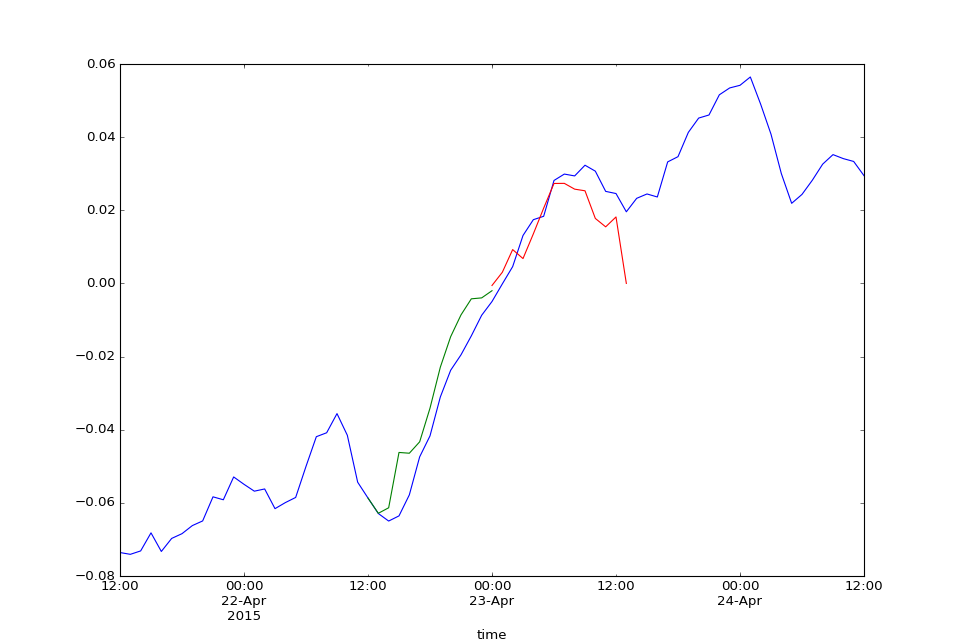

In [206]:
#plot
ax1=res1.unstack(level=0).plot(figsize=(12,8),legend=False)

<IPython.core.display.Javascript object>


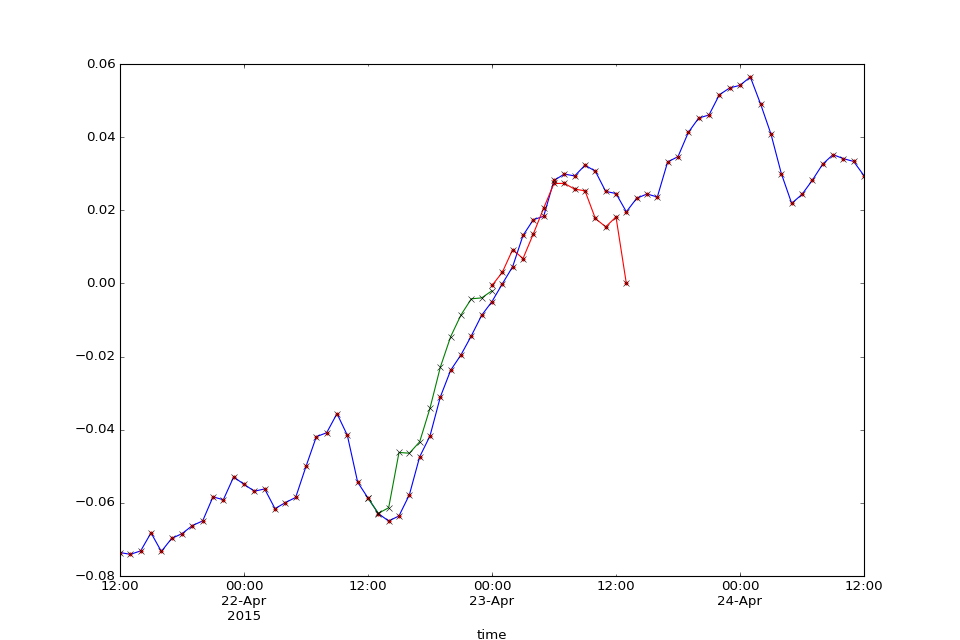

In [268]:
#plot both
ax1 = res1.unstack(level=0).plot(figsize=(12,8),legend=False)
res.unstack(level=0).plot(ax=ax1,color='red', linestyle='', marker='.',legend=False)

## SAVE DATA in CSV

In [415]:
SAVEPATH='tmp/'#/mnt/pandora/Users_Critech/Thomas/HYFLUX/'

In [416]:
res1.to_csv(SAVEPATH+obs['NAME'][point].strip()+'.csv', header=None)

## Fill gaps

In [244]:
index=[np.array(rt).ravel(),[item for sublist in ttw for item in sublist]]

In [245]:
index

[array([datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datetime.datetime(2015, 4, 21, 12, 0),
        datet

In [209]:
pIndex2=pandas.MultiIndex.from_arrays(index,names=['run date','time'])

In [210]:
res2=pandas.DataFrame(np.array(combined).ravel(),index=pIndex2,columns=['h - TIFF'])

<IPython.core.display.Javascript object>


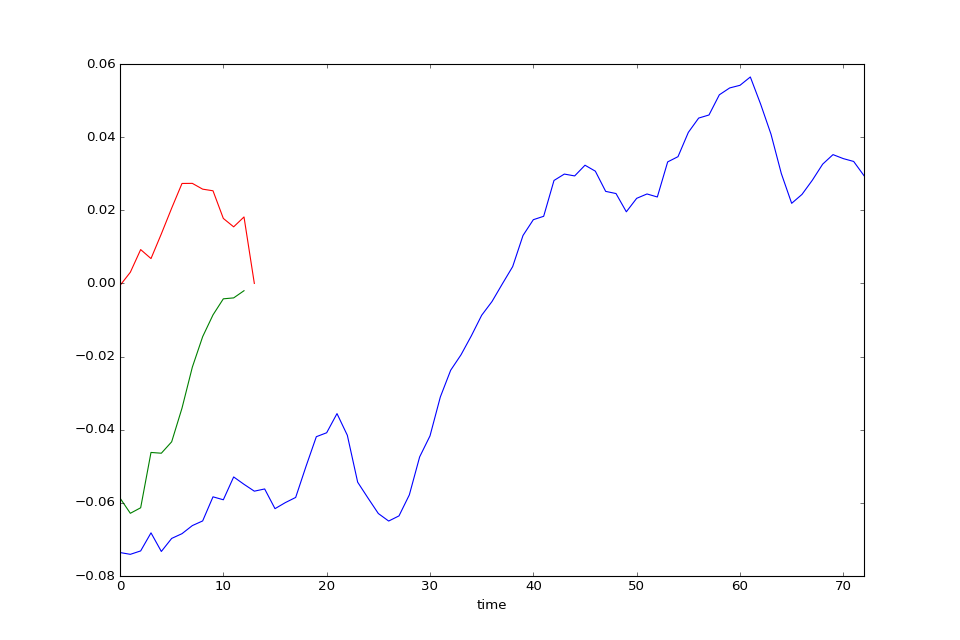

In [211]:
#plot
ax3=res2.unstack(level=0).plot(figsize=(12,8),legend=False)

In [262]:
index=[[a for (a,b) in res2.index.tolist()],[item+datetime.timedelta(hours=ik) for [(item,ik)] in zip(res2.index)]]

In [261]:
[a for (a,b) in res2.index.tolist()]

[Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-21 12:00:00'),
 Timestamp('2015-04-

In [263]:
pIndex3=pandas.MultiIndex.from_arrays(index,names=['run date','time'])

In [264]:
pIndex3

MultiIndex(levels=[[2015-04-21 12:00:00, 2015-04-22 12:00:00, 2015-04-23 00:00:00], [2015-04-21 12:00:00, 2015-04-21 13:00:00, 2015-04-21 14:00:00, 2015-04-21 15:00:00, 2015-04-21 16:00:00, 2015-04-21 17:00:00, 2015-04-21 18:00:00, 2015-04-21 19:00:00, 2015-04-21 20:00:00, 2015-04-21 21:00:00, 2015-04-21 22:00:00, 2015-04-21 23:00:00, 2015-04-22 00:00:00, 2015-04-22 01:00:00, 2015-04-22 02:00:00, 2015-04-22 03:00:00, 2015-04-22 04:00:00, 2015-04-22 05:00:00, 2015-04-22 06:00:00, 2015-04-22 07:00:00, 2015-04-22 08:00:00, 2015-04-22 09:00:00, 2015-04-22 10:00:00, 2015-04-22 11:00:00, 2015-04-22 12:00:00, 2015-04-22 13:00:00, 2015-04-22 14:00:00, 2015-04-22 15:00:00, 2015-04-22 16:00:00, 2015-04-22 17:00:00, 2015-04-22 18:00:00, 2015-04-22 19:00:00, 2015-04-22 20:00:00, 2015-04-22 21:00:00, 2015-04-22 22:00:00, 2015-04-22 23:00:00, 2015-04-23 00:00:00, 2015-04-23 01:00:00, 2015-04-23 02:00:00, 2015-04-23 03:00:00, 2015-04-23 04:00:00, 2015-04-23 05:00:00, 2015-04-23 06:00:00, 2015-04-23 0

### useful tidbits

In [265]:
res3=pandas.DataFrame(np.array(combined).ravel(),index=pIndex3,columns=['h - TIFF'])

In [269]:
res3.unstack(level=0).plot(ax=ax1,color='k', linestyle='', marker='x',legend=False)

In [266]:
res3


h - TIFF
run date            time                         
2015-04-21 12:00:00 2015-04-21 12:00:00 -0.073583
                    2015-04-21 13:00:00 -0.074074
                    2015-04-21 14:00:00 -0.073140
                    2015-04-21 15:00:00 -0.068201
                    2015-04-21 16:00:00 -0.073290
                    2015-04-21 17:00:00 -0.069725
                    2015-04-21 18:00:00 -0.068427
                    2015-04-21 19:00:00 -0.066217
                    2015-04-21 20:00:00 -0.064940
                    2015-04-21 21:00:00 -0.058350
                    2015-04-21 22:00:00 -0.059157
                    2015-04-21 23:00:00 -0.052914
                    2015-04-22 00:00:00 -0.054929
                    2015-04-22 01:00:00 -0.056806
                    2015-04-22 02:00:00 -0.056199
                    2015-04-22 03:00:00 -0.061588
                    2015-04-22 04:00:00 -0.059932
                    2015-04-22 05:00:00 -0.058518
                    2015-04-22 06:00:00 -0.050032
                    2015-04-22 07:00:00 -0.041908
                    2015-04-22 08:00:00 -0.040832
                    2015-04-22 09:00:00 -0.035594
                    2015-04-22 10:00:00 -0.041523
                    2015-04-22 11:00:00 -0.054347
                    2015-04-22 12:00:00 -0.058687
                    2015-04-22 13:00:00 -0.062917
                    2015-04-22 14:00:00 -0.064974
                    2015-04-22 15:00:00 -0.063562
                    2015-04-22 16:00:00 -0.057818
                    2015-04-22 17:00:00 -0.047423
...                                           ...
                    2015-04-24 10:00:00  0.034126
                    2015-04-24 11:00:00  0.033353
                    2015-04-24 12:00:00  0.029463
2015-04-22 12:00:00 2015-04-22 12:00:00 -0.058687
                    2015-04-22 13:00:00 -0.062855
                    2015-04-22 14:00:00 -0.061343
                    2015-04-22 15:00:00 -0.046216
                    2015-04-22 16:00:00 -0.046428
                    2015-04-22 17:00:00 -0.043308
                    2015-04-22 18:00:00 -0.034102
                    2015-04-22 19:00:00 -0.022895
                    2015-04-22 20:00:00 -0.014555
                    2015-04-22 21:00:00 -0.008603
                    2015-04-22 22:00:00 -0.004210
                    2015-04-22 23:00:00 -0.003955
                    2015-04-23 00:00:00 -0.001993
2015-04-23 00:00:00 2015-04-23 00:00:00 -0.000563
                    2015-04-23 01:00:00  0.003052
                    2015-04-23 02:00:00  0.009255
                    2015-04-23 03:00:00  0.006798
                    2015-04-23 04:00:00  0.013548
                    2015-04-23 05:00:00  0.020581
                    2015-04-23 06:00:00  0.027334
                    2015-04-23 07:00:00  0.027361
                    2015-04-23 08:00:00  0.025778
                    2015-04-23 09:00:00  0.025332
                    2015-04-23 10:00:00  0.017771
                    2015-04-23 11:00:00  0.015472
                    2015-04-23 12:00:00  0.018178
                    2015-04-23 13:00:00  0.000000

[100 rows x 1 columns]

In [62]:
s=res.xs('2015-04-23 00:00:00') # single day

In [63]:
s

,h - netCDF
time,
2015-04-23 00:00:00,-0.000563
2015-04-23 01:00:00,0.003052
2015-04-23 02:00:00,0.009255
2015-04-23 03:00:00,0.006798
2015-04-23 04:00:00,0.013548
2015-04-23 05:00:00,0.020581
2015-04-23 06:00:00,0.027334
2015-04-23 07:00:00,0.027361
2015-04-23 08:00:00,0.025778


### add missing values

In [64]:
s.index = pandas.DatetimeIndex(s.index)

In [65]:
idx = pandas.date_range('2015-04-23', '2015-04-24', freq='H')

In [66]:
s = s.reindex(idx[:-1], fill_value=np.nan)

In [88]:
s

,h - netCDF
2015-04-23 00:00:00,-0.000563
2015-04-23 01:00:00,0.003052
2015-04-23 02:00:00,0.009255
2015-04-23 03:00:00,0.006798
2015-04-23 04:00:00,0.013548
2015-04-23 05:00:00,0.020581
2015-04-23 06:00:00,0.027334
2015-04-23 07:00:00,0.027361
2015-04-23 08:00:00,0.025778
2015-04-23 09:00:00,0.025332


In [96]:
res1.loc[('2015-04-23 00:00:00',),'h - TIFF']

time
2015-04-23 00:00:00   -0.000563
2015-04-23 01:00:00    0.003052
2015-04-23 02:00:00    0.009255
2015-04-23 03:00:00    0.006798
2015-04-23 04:00:00    0.013548
2015-04-23 05:00:00    0.020581
2015-04-23 06:00:00    0.027334
2015-04-23 07:00:00    0.027361
2015-04-23 08:00:00    0.025778
2015-04-23 09:00:00    0.025332
2015-04-23 10:00:00    0.017771
2015-04-23 11:00:00    0.015472
2015-04-23 12:00:00    0.018178
2015-04-23 13:00:00    0.000000
Name: h - TIFF, dtype: float64

In [116]:
all_dates = [tstart + datetime.timedelta(hours=12*x)
    for x in range(ndt)]

In [117]:
all_dates

[datetime.datetime(2015, 4, 21, 12, 0),
 datetime.datetime(2015, 4, 22, 0, 0),
 datetime.datetime(2015, 4, 22, 12, 0),
 datetime.datetime(2015, 4, 23, 0, 0)]

In [146]:
res1.index.levels[1]

DatetimeIndex(['2015-04-21 12:00:00', '2015-04-21 13:00:00',
               '2015-04-21 14:00:00', '2015-04-21 15:00:00',
               '2015-04-21 16:00:00', '2015-04-21 17:00:00',
               '2015-04-21 18:00:00', '2015-04-21 19:00:00',
               '2015-04-21 20:00:00', '2015-04-21 21:00:00',
               '2015-04-21 22:00:00', '2015-04-21 23:00:00',
               '2015-04-22 00:00:00', '2015-04-22 01:00:00',
               '2015-04-22 02:00:00', '2015-04-22 03:00:00',
               '2015-04-22 04:00:00', '2015-04-22 05:00:00',
               '2015-04-22 06:00:00', '2015-04-22 07:00:00',
               '2015-04-22 08:00:00', '2015-04-22 09:00:00',
               '2015-04-22 10:00:00', '2015-04-22 11:00:00',
               '2015-04-22 12:00:00', '2015-04-22 13:00:00',
               '2015-04-22 14:00:00', '2015-04-22 15:00:00',
               '2015-04-22 16:00:00', '2015-04-22 17:00:00',
               '2015-04-22 18:00:00', '2015-04-22 19:00:00',
               '2015-04-

In [212]:
fres=res2.unstack().reindex(all_dates).fillna(0).stack()

In [213]:
fres

h - TIFF
run date            time          
2015-04-21 12:00:00 0    -0.073583
                    1    -0.074074
                    2    -0.073140
                    3    -0.068201
                    4    -0.073290
                    5    -0.069725
                    6    -0.068427
                    7    -0.066217
                    8    -0.064940
                    9    -0.058350
                    10   -0.059157
                    11   -0.052914
                    12   -0.054929
                    13   -0.056806
                    14   -0.056199
                    15   -0.061588
                    16   -0.059932
                    17   -0.058518
                    18   -0.050032
                    19   -0.041908
                    20   -0.040832
                    21   -0.035594
                    22   -0.041523
                    23   -0.054347
                    24   -0.058687
                    25   -0.062917
                    26   -0.064974
                    27   -0.063562
                    28   -0.057818
                    29   -0.047423
...                            ...
2015-04-23 00:00:00 43    0.000000
                    44    0.000000
                    45    0.000000
                    46    0.000000
                    47    0.000000
                    48    0.000000
                    49    0.000000
                    50    0.000000
                    51    0.000000
                    52    0.000000
                    53    0.000000
                    54    0.000000
                    55    0.000000
                    56    0.000000
                    57    0.000000
                    58    0.000000
                    59    0.000000
                    60    0.000000
                    61    0.000000
                    62    0.000000
                    63    0.000000
                    64    0.000000
                    65    0.000000
                    66    0.000000
                    67    0.000000
                    68    0.000000
                    69    0.000000
                    70    0.000000
                    71    0.000000
                    72    0.000000

[292 rows x 1 columns]

In [216]:
fres.xs('2015-04-23 00:00:00')

,h - TIFF
time,
0,-0.000563
1,0.003052
2,0.009255
3,0.006798
4,0.013548
5,0.020581
6,0.027334
7,0.027361
8,0.025778


In [ ]:
res1.ix[('20150102.00','2015-01-02 00:00:00'):('20150102.00','2015-01-02 12:00:00')] # slice of a day

In [ ]:
# for a time stamp and all days
res1.xs('2015-01-02 21:00:00', level=1)

In [ ]:
idx = pandas.IndexSlice

In [ ]:
base = datetime.datetime(2015, 4, 20, 0, 0)
arr = np.array([base + datetime.timedelta(hours=i) for i in xrange(0,365)])

In [ ]:
tix=pandas.to_datetime(arr).values.astype(str)

In [ ]:
tixl=list(tix)

In [ ]:
res1.loc[idx[:,tix],idx['h - TIFF']]

In [ ]:
res1.index.names[0]

In [ ]:
res2=res1.T

In [ ]:
res2[:5]

In [181]:
dates=pandas.date_range('20150101', periods=365)

In [176]:
values=np.empty((365,72))

In [178]:
values.fill(np.nan)

In [185]:
tsp=[]
for tsm in dates:
        for ih in xrange(72):
                tsp.append(tsm+datetime.timedelta(hours=ih))

In [186]:
tsp

[Timestamp('2015-01-01 00:00:00', offset='D'),
 Timestamp('2015-01-01 01:00:00', offset='D'),
 Timestamp('2015-01-01 02:00:00', offset='D'),
 Timestamp('2015-01-01 03:00:00', offset='D'),
 Timestamp('2015-01-01 04:00:00', offset='D'),
 Timestamp('2015-01-01 05:00:00', offset='D'),
 Timestamp('2015-01-01 06:00:00', offset='D'),
 Timestamp('2015-01-01 07:00:00', offset='D'),
 Timestamp('2015-01-01 08:00:00', offset='D'),
 Timestamp('2015-01-01 09:00:00', offset='D'),
 Timestamp('2015-01-01 10:00:00', offset='D'),
 Timestamp('2015-01-01 11:00:00', offset='D'),
 Timestamp('2015-01-01 12:00:00', offset='D'),
 Timestamp('2015-01-01 13:00:00', offset='D'),
 Timestamp('2015-01-01 14:00:00', offset='D'),
 Timestamp('2015-01-01 15:00:00', offset='D'),
 Timestamp('2015-01-01 16:00:00', offset='D'),
 Timestamp('2015-01-01 17:00:00', offset='D'),
 Timestamp('2015-01-01 18:00:00', offset='D'),
 Timestamp('2015-01-01 19:00:00', offset='D'),
 Timestamp('2015-01-01 20:00:00', offset='D'),
 Timestamp('2

In [223]:
[tsm+datetime.timedelta(hours=ih) for (tsm.ih) in dates and ih in range(72)]

ValueError: The truth value of a DatetimeIndex is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [57]:
indx=pandas.MultiIndex.from_arrays(index,names=['run date','time'])

In [ ]:
df = pandas.DataFrame(np.empty, index=dates